<a href="https://colab.research.google.com/github/suhrobm/Methods-and-Models-for-Multivariate-Data-Analysis/blob/main/Lab4_Suhrob_Munavarov_J4134c.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# TASK 4. Stationarity of the processes

---


### Content 🎯


1. Substantiation of chosen sampling
2. Stationary analysis
3. Covariance or correlation function analysis
4. Noise filtration
5. Estimation of spectral density function
6. Auto-regression model
7. Model in a form of linear dynamical system


# **About Dataset**

In this task, the previous chosen dataset is being used.

### 1. Substantiation of chosen sampling

Preparing our data by choosing the subsample from our dataset to make the further implementations

In [1]:
!pip install fedot

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import networkx as nx
import scipy.stats
import statsmodels.api as sm
import seaborn as sns
import statsmodels.tsa.api as smt
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa import stattools
import scipy
from scipy import signal
from fedot.core.data.data import InputData
from fedot.core.pipelines.pipeline import Pipeline
from fedot.core.repository.dataset_types import DataTypesEnum
from fedot.core.repository.tasks import Task, TaskTypesEnum, TsForecastingParams
from fedot.core.pipelines.node import PrimaryNode, SecondaryNode
from fedot.core.data.data_split import train_test_data_setup
from itertools import product
from datetime import datetime
from fedot.core.data.multi_modal import MultiModalData
from sklearn.model_selection import train_test_split
from scipy.stats import shapiro
from statsmodels.tsa.vector_ar.var_model import VAR
import statsmodels.tsa.api as smt
import warnings

from google.colab import drive
drive.mount('/content/drive')

# prevents numpy scientific/exponential notation on print, default is False
# force-suppressing the scientific notation, it is rounded and justified
np.set_printoptions(suppress=False, formatter={'float_kind':'{:0.2f}'.format})
# ignoring warnings
warnings.filterwarnings('ignore')
warnings.warn('DelftStack')
warnings.warn('Do not show this message')


Mounted at /content/drive


In [3]:
# Reading whole dataset from file and loading the data and save it in a DataFrame 
df = pd.read_csv('/content/drive/MyDrive/MMMDA/Housing price in Beijing.csv', encoding = 'ISO-8859-1')
print(df.shape)
df.head(3)

(318851, 26)


,url,id,Lng,Lat,Cid,tradeTime,DOM,followers,totalPrice,price,...,buildingType,constructionTime,renovationCondition,buildingStructure,ladderRatio,elevator,fiveYearsProperty,subway,district,communityAverage
0,https://bj.lianjia.com/chengjiao/101084782030....,101084782030,116.475489,40.019520,1111027376244,2016-08-09,1464.0,106,415.0,31680,...,1.0,2005,3,6,0.217,1.0,0.0,1.0,7,56021.0
1,https://bj.lianjia.com/chengjiao/101086012217....,101086012217,116.453917,39.881534,1111027381879,2016-07-28,903.0,126,575.0,43436,...,1.0,2004,4,6,0.667,1.0,1.0,0.0,7,71539.0
2,https://bj.lianjia.com/chengjiao/101086041636....,101086041636,116.561978,39.877145,1111040862969,2016-12-11,1271.0,48,1030.0,52021,...,4.0,2005,3,6,0.500,1.0,0.0,0.0,7,48160.0


In [4]:
# creating subsamples by specifying the predictor variables and the target variable (totalPrice)
df_sample = df[['tradeTime', 'square', 'renovationCondition', 'buildingType', 'elevator', 'totalPrice']]
df_sample = pd.DataFrame(df_sample)
df_sample = df_sample.iloc[:150000, :]

# timestamps to daily
df_sample['tradeTime'] = pd.to_datetime(df_sample['tradeTime'], infer_datetime_format=True )
df_sample['tradeTime'] = df_sample['tradeTime'].dt.round('1h')  

# aggregation with indexing
df_daily_tradetime = df_sample.groupby('tradeTime', as_index=False).agg({"square": "median", "renovationCondition": "median", "buildingType": "median", "elevator": "median", "totalPrice": "median" }) 
df_daily_tradetime = df_daily_tradetime.sort_values('tradeTime')
df_daily_tradetime.index = pd.date_range(freq="h", start=df_daily_tradetime["tradeTime"][0], periods=len(df_daily_tradetime['tradeTime']))

# aggregation without indexing
df_daily_tradetime_ni = df_sample.groupby('tradeTime', as_index=False).agg({"square": "median", "renovationCondition": "median", "buildingType": "median", "elevator": "median", "totalPrice": "median" }) 
df_daily_tradetime_ni=df_daily_tradetime_ni.sort_values('tradeTime')



### 2. Stationary analysis

with indexing

square: Augmented Dickey-Fuller test:
 Statistic value = -2.662226
 p-value = 0.080806
square variable is not stationary, the data will be normalized


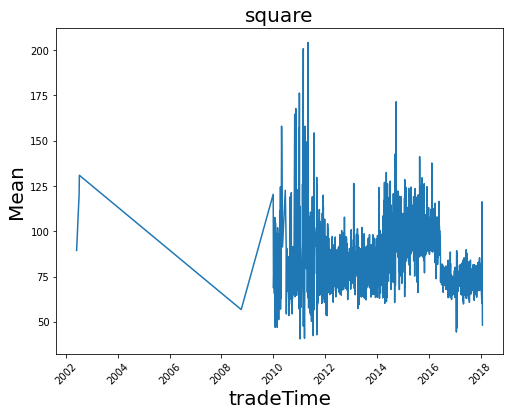

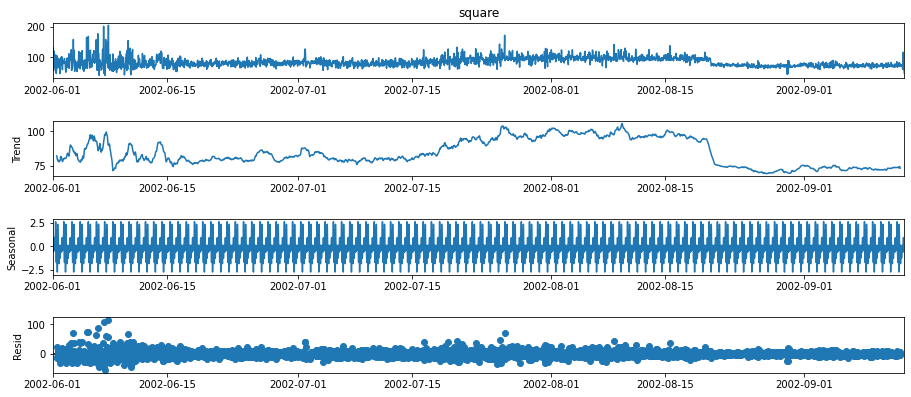

In [5]:
# Defining a function to plot and write stationarity information
def stationarity(column_name, df):
    p_threshold = 0.005
    plt.figure(figsize=(8, 6))
    plt.plot(df['tradeTime'], df[column_name])
    plt.xticks(rotation=45)
    plt.xlabel(u'tradeTime', fontsize = 20) 
    plt.ylabel(u'Mean', fontsize = 20)
    plt.title(column_name, fontsize = 20)
    # Testing , lower p-value --> more stationary
    result = smt.stattools.adfuller(df[column_name])
    print(column_name + ': Augmented Dickey-Fuller test:\n Statistic value = %5f\n p-value = %5f' % (result[0], result[1]))
    if result[1] < p_threshold:
        print(f'{column_name} variable is stationary\n')
    else:
        print(f'{column_name} variable is not stationary, the data will be normalized')
    result = seasonal_decompose((df[column_name]), model='additive')
    fig=result.plot()
    fig.set_figheight(6)
    fig.set_figwidth(14)
    plt.show()
    return df

# square variable

df_daily_tradetime_square = stationarity('square',df_daily_tradetime)



Augmented Dickey-Fuller test:
 Statistic value = -20.584356
 p-value = 0.000000
square is stationary

square: Augmented Dickey-Fuller test:
 Statistic value = -2.659048
 p-value = 0.081397
square variable is not stationary, the data will be normalized


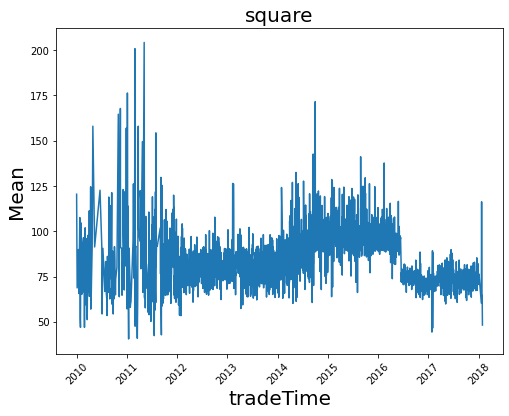

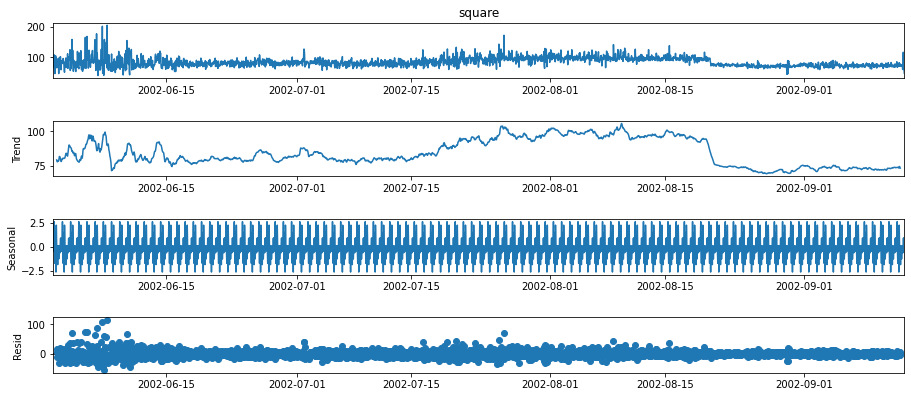

In [6]:
p_threshold = 0.005
result = smt.stattools.adfuller(df_sample['square'])
print('Augmented Dickey-Fuller test:\n Statistic value = %5f\n p-value = %5f' % (result[0], result[1]))
if result[1] < p_threshold:
    print('square is stationary\n')
else:
    print('square is not stationary, the data will be normalized')

# for square variable, taking the half of the data, right side of the data to be worked on
# spliting data into 2 parts
df_daily_tradetime_half = df_daily_tradetime[df_daily_tradetime.tradeTime > datetime(2009,6,1)] 

# Checking the stationarity of square variable again 
df_daily_tradetime_square_half = stationarity('square', df_daily_tradetime_half)



without indexing

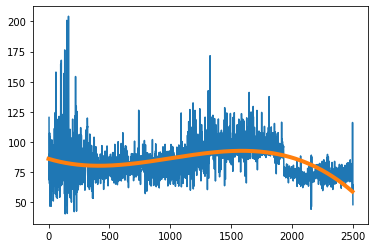

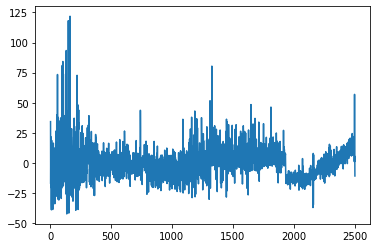

In [7]:
# taking the half of data of the non indexed data
df_daily_tradetime_half_ni = df_daily_tradetime_ni[df_daily_tradetime_ni.tradeTime > datetime(2009,6,1)] 

# defining a function to find the trend
def trendline(data, order=9):
    #polynomial trend
    trend = np.polyfit(data.index.values, list(data), order)
    return np.poly1d(trend)(data.index.values)

trend = trendline(df_daily_tradetime_half_ni['square'], 3) # finding the trend
plt.plot(df_daily_tradetime_half_ni['square'])             # plotting the data
plt.plot(trend, linewidth=4)                               # plotting the trend
plt.show()
new_square = df_daily_tradetime_half_ni['square']-trend    # deleting the trend from the column
plt.plot(df_daily_tradetime_half_ni['square']-trend)       # plotting after deleting the trend
plt.show()



buildingType: Augmented Dickey-Fuller test:
 Statistic value = -6.414641
 p-value = 0.000000
buildingType variable is stationary



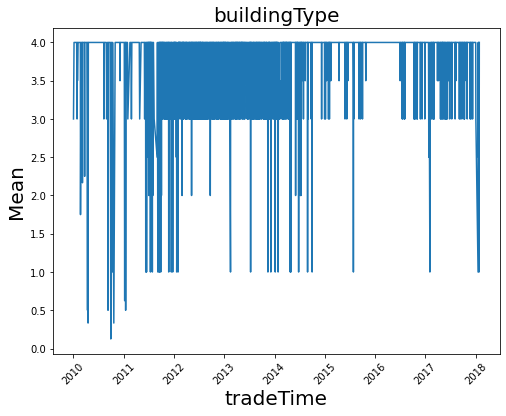

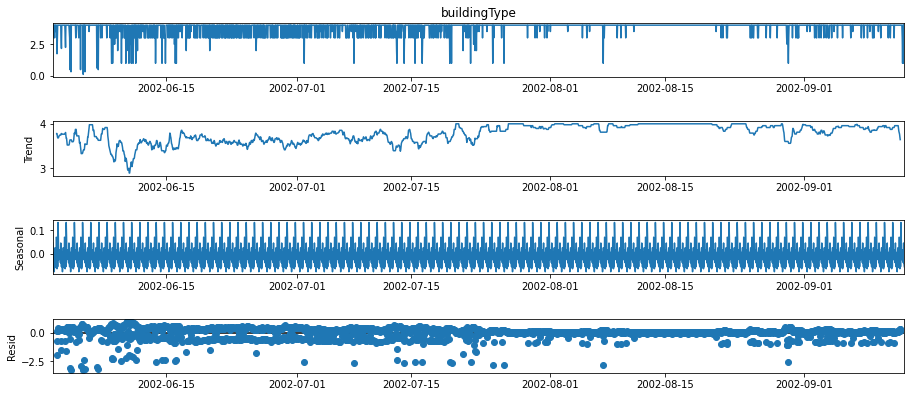

In [8]:
# buildingType variable, repeating all steps applied for the square variable 
df_daily_tradetime_buildingType_half = stationarity('buildingType', df_daily_tradetime_half) 


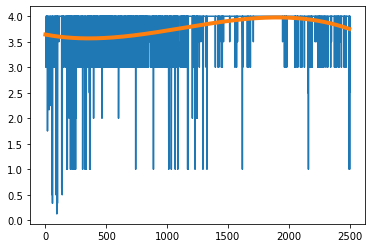

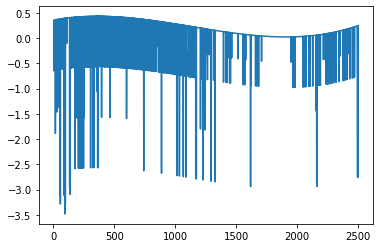

In [9]:
trend = trendline(df_daily_tradetime_half_ni['buildingType'], 3)
plt.plot(df_daily_tradetime_half_ni['buildingType'])#
plt.plot(trend, linewidth=4)
plt.show()
new_buildingType = df_daily_tradetime_half_ni['buildingType']-trend
plt.plot(df_daily_tradetime_half_ni['buildingType']-trend)
plt.show()


totalPrice: Augmented Dickey-Fuller test:
 Statistic value = -1.090619
 p-value = 0.718798
totalPrice variable is not stationary, the data will be normalized


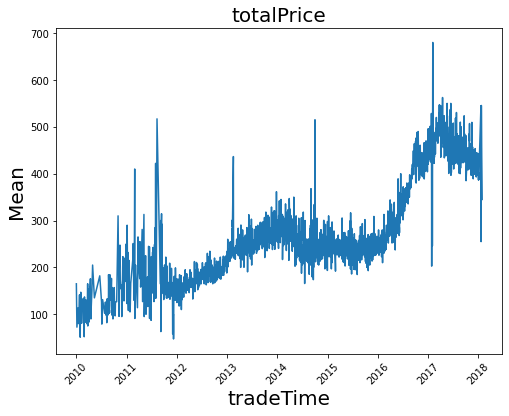

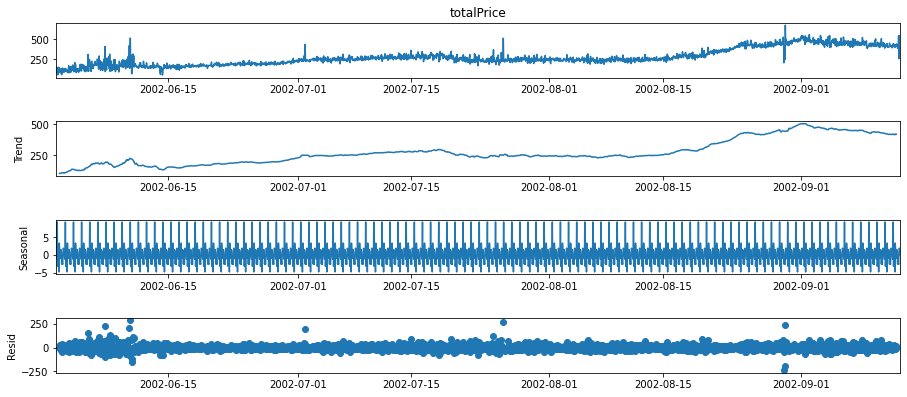

In [10]:
# totalPrice variable, repeating all steps applied for the square variable 
df_daily_tradetime_totalPrice_half = stationarity('totalPrice', df_daily_tradetime_half) 

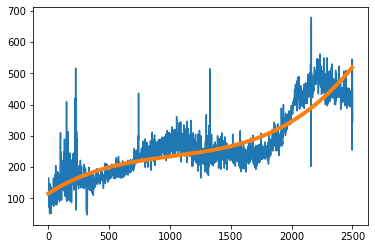

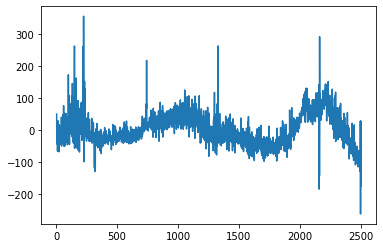

In [11]:
trend = trendline(df_daily_tradetime_half_ni['totalPrice'], 3)
plt.plot(df_daily_tradetime_half_ni['totalPrice'])#
plt.plot(trend, linewidth=4)
plt.show()
new_totalPrice = df_daily_tradetime_half_ni['totalPrice']-trend
plt.plot(df_daily_tradetime_half_ni['totalPrice']-trend)
plt.show()

checking stationanarity after removing process for each variable

In [12]:
# creating a dataset out of the column where were deleted.
data_stationary = {'tradeTime': df_daily_tradetime_ni['tradeTime'],
                   'square': new_square,
                   'buildingType': new_buildingType,
                   'totalPrice': new_totalPrice}  
data_stationary = pd.DataFrame(data_stationary)  
data_stationary_ni= pd.DataFrame(data_stationary)  
# Checking if there is null values and deleting them
data_stationary.isnull().sum()
data_stationary = data_stationary.dropna()
# nonindexed
data_stationary_ni.isnull().sum()
data_stationary_ni = data_stationary_ni.dropna()
# Print the output.  
print(data_stationary) 
# make the new created data time indexed
# data_stationary
data_stationary.reset_index(inplace = True,drop = True)
data_stationary.index = pd.date_range(freq="h", start = data_stationary["tradeTime"][0], periods = len(data_stationary['tradeTime']))

      tradeTime     square  buildingType  totalPrice
4    2010-01-01  34.280538     -0.641166   49.144234
5    2010-01-05 -17.389223      0.359283  -43.605132
6    2010-01-15   3.830924      0.359731   -2.354107
7    2010-01-16 -14.349020      0.360177  -32.602694
8    2010-01-18 -20.419056      0.360622  -36.850891
...         ...        ...           ...         ...
2498 2018-01-20   0.915472      0.245120 -262.427471
2499 2018-01-22  56.921818     -1.254048   27.601972
2500 2018-01-24   1.148301      0.246785  -58.369152
2501 2018-01-26   5.434922     -2.752379 -108.840843
2502 2018-01-28 -10.878321      0.248458 -174.313103

[2499 rows x 4 columns]


square: Augmented Dickey-Fuller test:
 Statistic value = -4.059545
 p-value = 0.001129
square variable is stationary



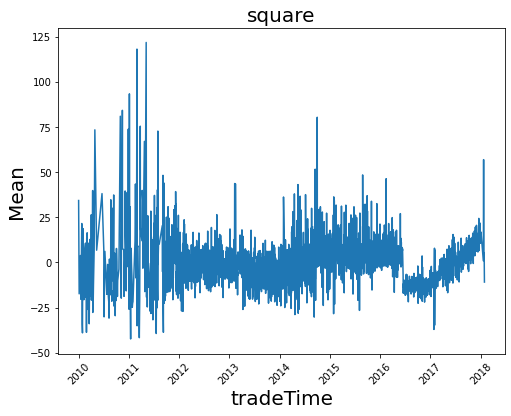

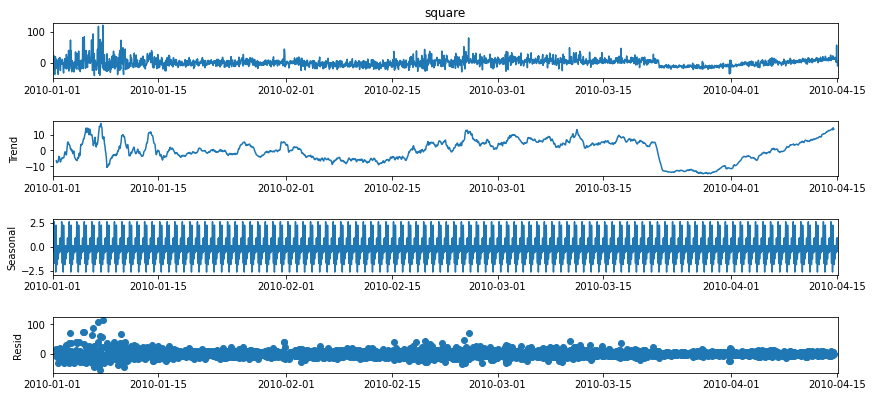

In [13]:
df_daily_square_stationarity = stationarity('square', data_stationary)


buildingType: Augmented Dickey-Fuller test:
 Statistic value = -12.182250
 p-value = 0.000000
buildingType variable is stationary



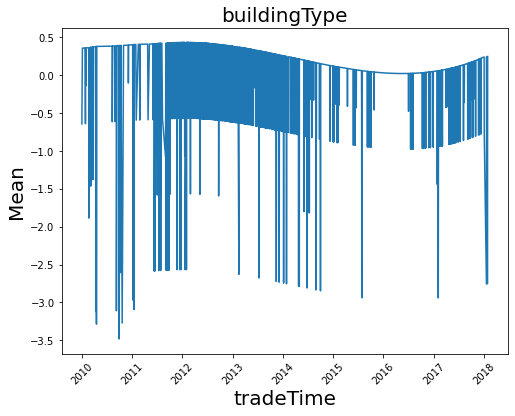

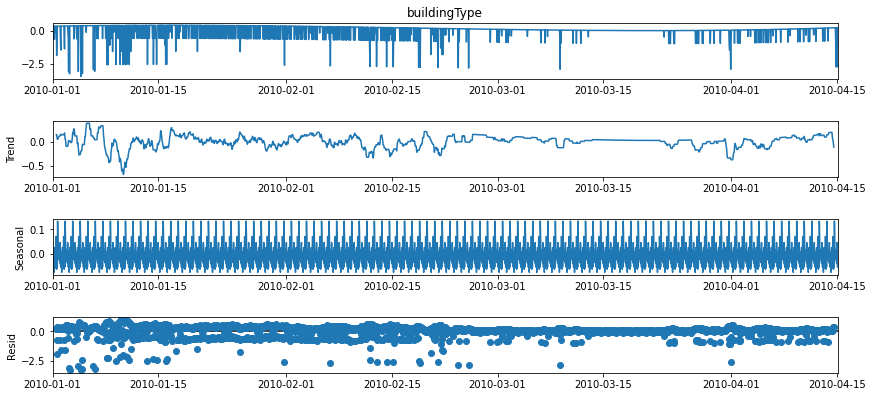

In [14]:
df_daily_buildingType_stationarity = stationarity('buildingType',data_stationary)

totalPrice: Augmented Dickey-Fuller test:
 Statistic value = -1.446415
 p-value = 0.559833
totalPrice variable is not stationary, the data will be normalized


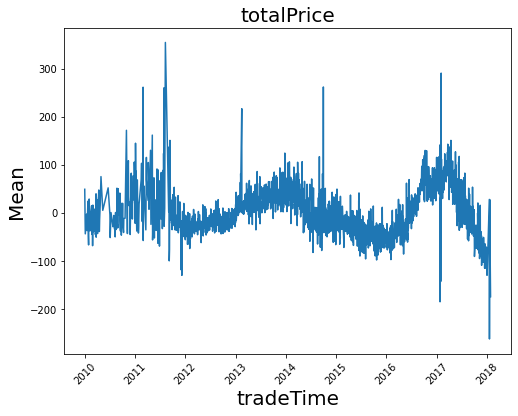

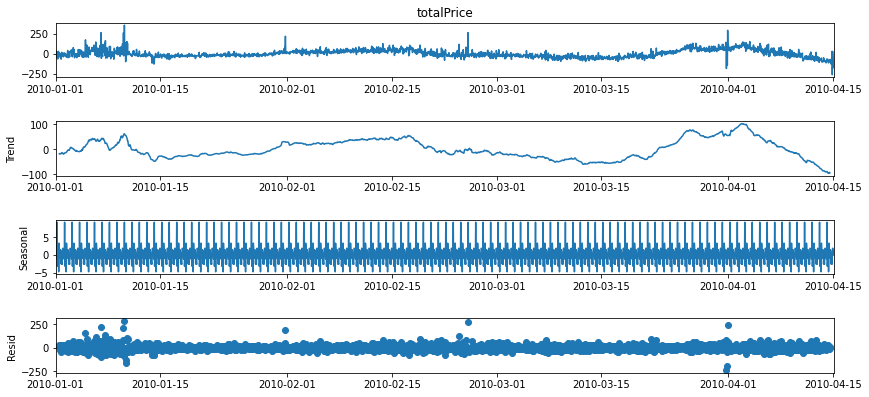

In [15]:
df_daily_totalPrice_stationarity=stationarity('totalPrice',data_stationary)

### 3. Covariance or correlation function analysis

Text(0.5, 1.0, 'totalPrice')

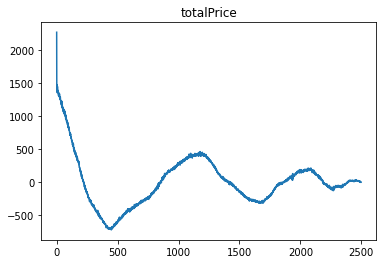

In [40]:
# covariance for the totalPrice target, autocovariance without window
plt.plot(stattools.acovf(data_stationary['totalPrice'], fft=False)) 
plt.title("totalPrice")



Mutual correlation functions among predictors and targets

In [17]:
# calculating var (t-1) from var (t) by shifting the var list one step
square_previous_t = np.roll(data_stationary['square'],1)  # predictor
buildingType_previous_t = np.roll(data_stationary['buildingType'],1)  # predictor
totalPrice_previous_t = np.roll(data_stationary['totalPrice'],1)  # target

# creating a dataset out of the var (t) and var (t-1)
data_correlated = {
            'square': data_stationary['square'],
            'square (t-1)': square_previous_t,
            'buildingType': data_stationary['buildingType'],
            'buildingType (t-1)': buildingType_previous_t,
            'totalPrice': data_stationary['totalPrice'],
            'totalPrice (t-1)': totalPrice_previous_t}  

data_correlated = pd.DataFrame(data_correlated)  

# finding mutual correlation for the data var (t) and var (t-1)
data_correlated.corr()



,square,square (t-1),buildingType,buildingType (t-1),totalPrice,totalPrice (t-1)
square,1.000000,0.212744,0.017838,0.050711,0.072076,-0.264627
square (t-1),0.212744,1.000000,0.033267,0.017838,-0.270395,0.072076
buildingType,0.017838,0.033267,1.000000,0.051982,-0.142392,-0.044783
buildingType (t-1),0.050711,0.017838,0.051982,1.000000,-0.036715,-0.142392
totalPrice,0.072076,-0.270395,-0.142392,-0.036715,1.000000,0.611711
totalPrice (t-1),-0.264627,0.072076,-0.044783,-0.142392,0.611711,1.000000


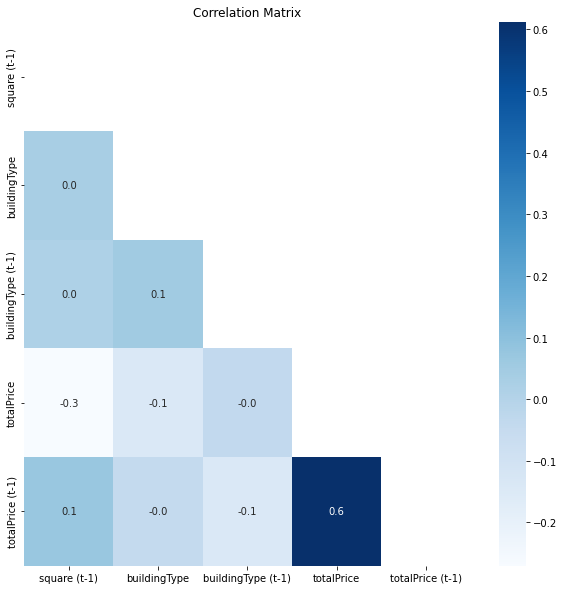

In [18]:
# pair correlation coefficients, correlation Matrix for the data var (t) and var (t-1)
fig, ax = plt.subplots(figsize=(10,10))
corr = data_correlated[data_correlated.columns[1:]].corr()
mask = np.zeros_like(corr, dtype=bool)
mask[np.triu_indices_from(mask)] = True
sns.heatmap(corr, mask=mask, annot=True,  fmt='.1f',ax=ax, cmap = 'Blues')
plt.title('Correlation Matrix')
plt.show()



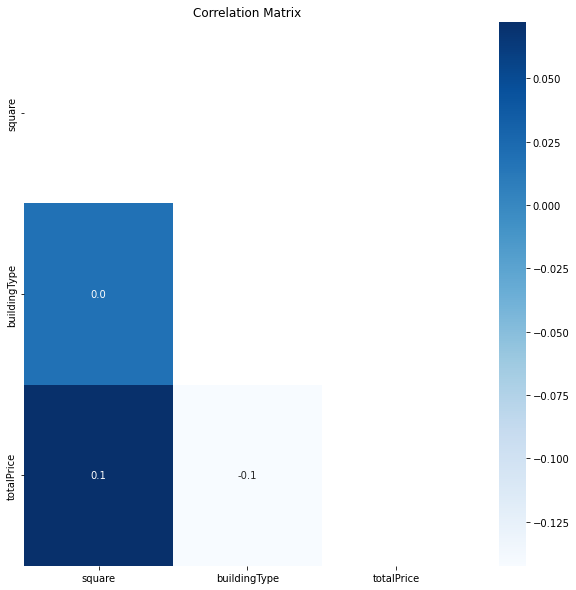

In [19]:
# pair correlation coefficients, correlation Matrix, for the data var (t)
fig, ax = plt.subplots(figsize=(10,10))
corr = data_stationary[data_stationary.columns[1:]].corr()
mask = np.zeros_like(corr, dtype=bool)
mask[np.triu_indices_from(mask)] = True
sns.heatmap(corr, mask=mask, annot=True,  fmt='.1f',ax=ax, cmap = 'Blues')
plt.title('Correlation Matrix')
plt.show()

### 4. Filter high frequencies (noise) with chosen 1 filter for target variable (totalPrice)


INFO:summarizer.preprocessing.cleaner:'pattern' package not found; tag filters are not available for English


2023-03-12 09:05:23,194 - 'pattern' package not found; tag filters are not available for English


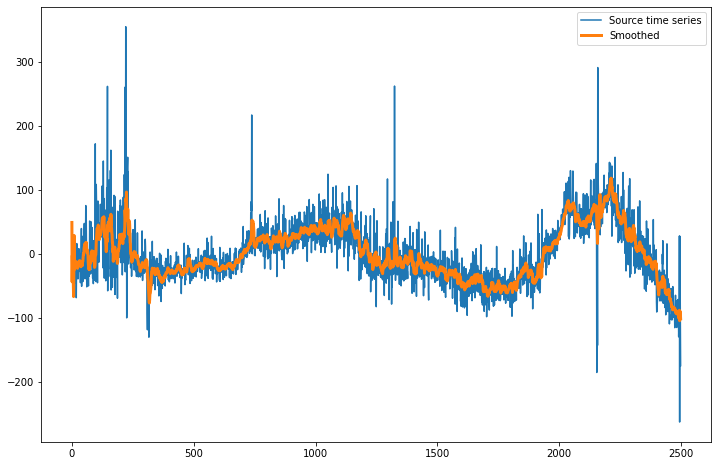

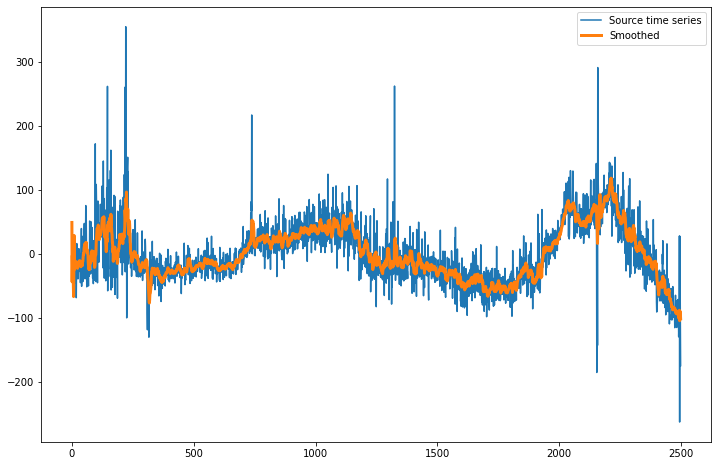

In [20]:
# totalPrice filtering

# data preperation, convert into numpy array first
time_series=np.array(data_stationary["totalPrice"])
# fedot data preparation
# Define task - time series forecasting
# and forecast horizon 
task = Task (TaskTypesEnum.ts_forecasting, TsForecastingParams(forecast_length=25))
input_data = InputData(idx=np.arange(0, len(time_series)),
features = time_series, target=time_series,
task = task, data_type=DataTypesEnum.ts)

# square Rolling Mean Filtering

# rolling mean window smoothing
def Rolling_square(window_size):
    smoothing_node = PrimaryNode('smoothing')
    smoothing_node.custom_params = {'window_size': window_size}
    def node_fit_predict(node, input_data):
        """ Fit node and make prediction """
        node.fit(input_data)
        smoothed_output = node.predict(input_data)
        return smoothed_output
    smoothed_output = node_fit_predict(smoothing_node, input_data)
    fig, ax = plt.subplots(figsize=(12,8))
    plt.plot(input_data.idx, input_data.target, label='Source time series')
    plt.plot(smoothed_output.idx, smoothed_output.predict, label='Smoothed', linewidth=3)
    plt.legend()
    plt.show()
    return smoothed_output


smoothed_output_1 = Rolling_square(3)
smoothed_output_2 = Rolling_square(20)



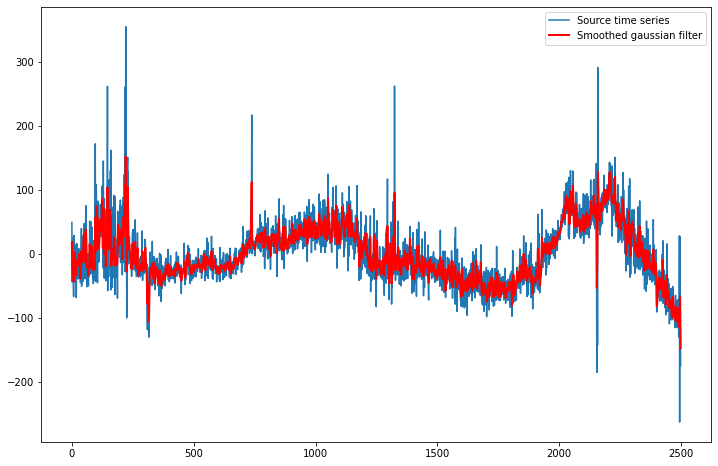

In [21]:
# T2 Gaussian Filter - compare results - summary plots

smoothing_node = PrimaryNode('smoothing') 
smoothing_node.custom_params = {'window_size': 15}

def node_fit_predict(node, input_data):
    """ Fit node and make prediction """
    node.fit(input_data)
    smoothed_output = node.predict(input_data)
    return smoothed_output

smoothed_output = node_fit_predict(smoothing_node, input_data)

gaussian_node = PrimaryNode('gaussian_filter') 
gaussian_node.custom_params = {'sigma': 8}
smoothed_gaussian = node_fit_predict(gaussian_node, input_data)
fig, ax = plt.subplots(figsize=(12,8))
plt.plot(input_data.idx, input_data.target, label='Source time series')
plt.plot(smoothed_gaussian.idx, smoothed_gaussian.predict, label='Smoothed gaussian filter', linewidth=2, c='red')
plt.legend()
plt.show()


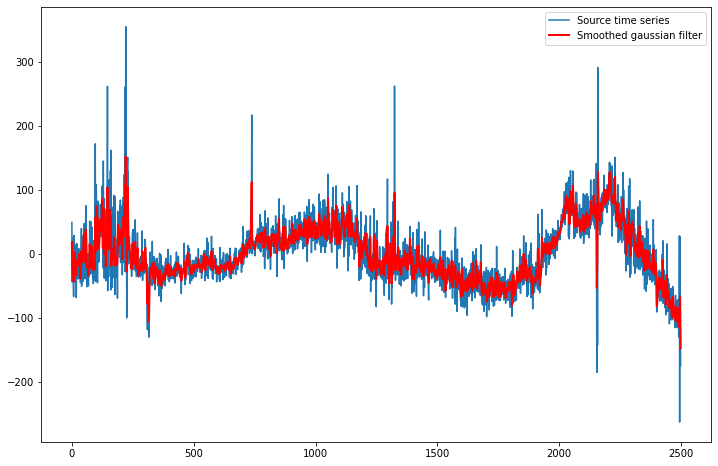

In [22]:
gaussian_node = PrimaryNode('gaussian_filter') 
gaussian_node.custom_params = {'sigma': 5}
smoothed_gaussian_2 = node_fit_predict(gaussian_node, input_data)
fig, ax = plt.subplots(figsize=(12,8))
plt.plot(input_data.idx, input_data.target, label='Source time series')
plt.plot(smoothed_gaussian_2.idx, smoothed_gaussian_2.predict, label='Smoothed gaussian filter', linewidth=2, c='red')
plt.legend()
plt.show()



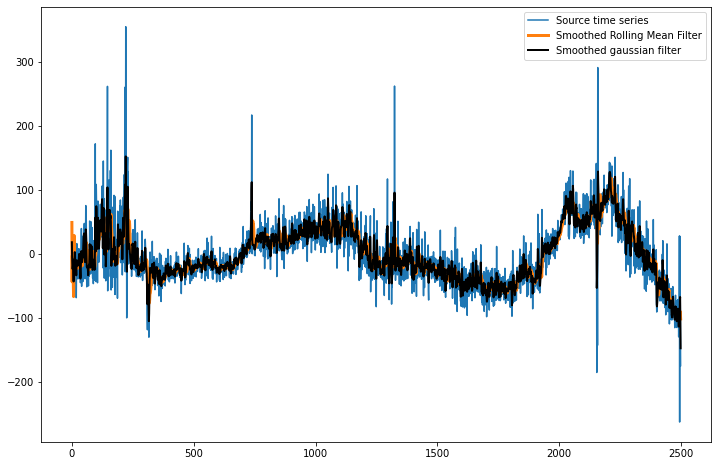

In [23]:
# square both filters
fig, ax = plt.subplots(figsize=(12,8))
plt.plot(input_data.idx, input_data.target, label='Source time series')
plt.plot(smoothed_output_2.idx, smoothed_output_2.predict, label='Smoothed Rolling Mean Filter', linewidth=3)
plt.plot(smoothed_gaussian.idx, smoothed_gaussian.predict, label='Smoothed gaussian filter', linewidth=2, c='black')
plt.legend()
plt.show()



### 5. Spectral density function with and without filtering

2499


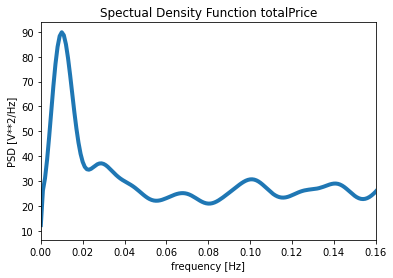

In [24]:
# to analyze results after filtering

def Spec_Den_Fun(data,variable,name):
    window_size = 50
    blackman = signal.blackman(M=window_size)
    bartlett = signal.hann(M=window_size)
    print(len(data))
    f, Pxx_den = signal.welch(variable, fs=1, scaling='spectrum', nfft = 1000, nperseg=100)
    f_window, Pxx_den_window = signal.welch(variable, fs=1, window = blackman, nfft = 1000, scaling='spectrum')
    f_window_bart, Pxx_den_window_bart = signal.welch(variable, fs=1, window = bartlett, nfft = 1000, scaling='spectrum')
    plt.plot(f, Pxx_den, linewidth=4)
    #plt.plot(f_window, Pxx_den_window)
    #plt.plot(f_window_bart, Pxx_den_window_bart)
    plt.xlabel('frequency [Hz]')
    plt.ylabel('PSD [V**2/Hz]')
    plt.xlim((0,0.16))
    plt.title("Spectual Density Function "+ name)
    plt.show()


# totalPrice, spectral density function totalPrice without filtering
Spec_Den_Fun(data_stationary, data_stationary["totalPrice"], 'totalPrice')




2499


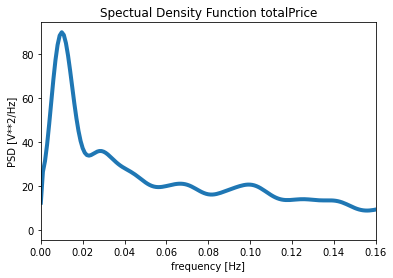

In [25]:
# Spectral density function totalPrice with filtering
# The filtered data is from the previous step,
# the original data filtered by Gaussian Filter with sigma value equal to eight.
Spec_Den_Fun(smoothed_gaussian.predict,smoothed_gaussian.predict,'totalPrice')



### 6. Built auto-regression model filtered and non-filtered data

To analyze residual error and to define appropriate order of model


In [26]:
# totalPrice variable, totalPrice not filttered SARIMA and AIC model

ps = range(0, 6)
d=1
qs = range(0, 6)
Ps = range(0, 2)
D=1
Qs= range(0,1)
parameters = product(ps, qs, Ps, Qs)
parameters_list = list(parameters)
print (u"Models to analyse by AIC:", len(parameters_list))



Models to analyse by AIC: 72


In [27]:
results = []
best_aic = float("inf")
for param in parameters_list:
    # trying fitting the data to SARIMAX model with different order/seasonal order
    # to try to find the best coefficients
    #try except for the case of wrong parameters
    try:
        model =sm.tsa.statespace.SARIMAX(np.array(data_stationary['totalPrice']), order=(param[0], d, param[1]), 
                                        seasonal_order=(param[2], D, param[3], 2)).fit(disp=-1)
    #print wrong parameters and go on
    # AIC criteria:
    except BaseException as ex:
        continue
    aic = model.aic
    # save best model, aic, parameters
    if (aic < best_aic):
        best_model = model
        best_aic = aic
        best_param = param
    results.append([param, model.aic])

In [28]:
result_table = pd.DataFrame(results)
result_table.columns = ['parameters', 'aic']
print(result_table.sort_values(by = 'aic', ascending=True).head())

      parameters           aic
47  (5, 5, 0, 0)  24116.038449
45  (5, 3, 0, 0)  24118.762722
29  (2, 5, 0, 0)  24126.842359
39  (4, 3, 0, 0)  24126.957948
34  (3, 4, 0, 0)  24134.314397


In [29]:
print(best_model.summary())

                                     SARIMAX Results                                      
Dep. Variable:                                  y   No. Observations:                 2499
Model:             SARIMAX(5, 1, 5)x(0, 1, [], 2)   Log Likelihood              -12047.019
Date:                            Sun, 12 Mar 2023   AIC                          24116.038
Time:                                    09:08:13   BIC                          24180.085
Sample:                                         0   HQIC                         24139.292
                                           - 2499                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.8324      0.017     49.075      0.000       0.799       0.866
ar.L2         -0.9273      0.016   

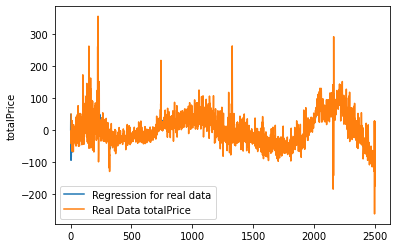

 We can see that the prediction for the existed data is good, the difference between statistical models        and machine learning models, is that statistical models are not so affected by the overfitting,         so we can simply compare the result for train sample and if statistical model repressent (cover)         the training data well --> the model has a strict structure and we can use it for forecasting the future


In [30]:
plt.plot(best_model.fittedvalues, label='Regression for real data')
plt.plot(data_stationary_ni['totalPrice'], label = 'Real Data totalPrice')
plt.ylabel('totalPrice')
plt.legend()
plt.show()
print(' We can see that the prediction for the existed data is good, the difference between statistical models\
        and machine learning models, is that statistical models are not so affected by the overfitting, \
        so we can simply compare the result for train sample and if statistical model repressent (cover) \
        the training data well --> the model has a strict structure and we can use it for forecasting the future.')


Dickey-Fuller test: p=0.0000000000000000000000000
ShapiroResult(statistic=0.8816547393798828, pvalue=4.584964497362942e-40)


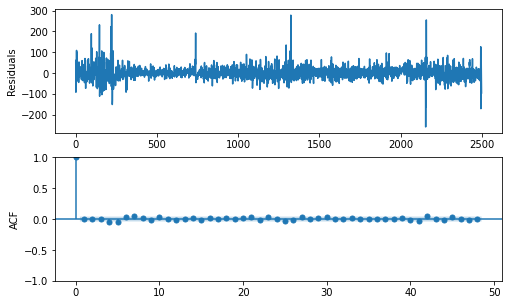

In [31]:
# Residuals
plt.figure(figsize=(8,5))
ax = plt.subplot(211)
plt.plot(best_model.resid)
plt.ylabel('Residuals')
# ACF
ax = plt.subplot(212)
sm.graphics.tsa.plot_acf(best_model.resid.squeeze(), lags=48, ax=ax, title=None)
plt.ylabel('ACF')
print("Dickey-Fuller test: p=%.25f" % sm.tsa.stattools.adfuller(best_model.resid)[1])
# Testing Normality
print (shapiro(best_model.resid))

In [32]:
results_2 = []
best_aic = float("inf")
for param in parameters_list:
    # trying fitting the data to SARIMAX model with different order/seasonal order
    # to try to find the best coefficients
    #try except for the case of wrong parameters
    try:
        model =sm.tsa.statespace.SARIMAX(smoothed_gaussian.predict, order=(param[0], d, param[1]), 
                                        seasonal_order=(param[2], D, param[3], 2)).fit(disp=-1)
    #print wrong parameters and go on
    # AIC criteria:
    except BaseException as ex:
        continue
    aic = model.aic
    # save best model, aic, parameters
    if (aic < best_aic):
        best_model = model
        best_aic = aic
        best_param = param
    results_2.append([param, model.aic])

result_table_2 = pd.DataFrame(results_2)
result_table_2.columns = ['parameters', 'aic']
print(result_table_2.sort_values(by = 'aic', ascending=True).head())



      parameters           aic
46  (5, 4, 0, 0)  16111.731410
41  (4, 5, 0, 0)  16129.206468
22  (1, 5, 0, 0)  16138.370519
23  (1, 5, 1, 0)  16139.405273
29  (2, 5, 0, 0)  16139.560942


In [33]:
print(best_model.summary())

                                     SARIMAX Results                                      
Dep. Variable:                                  y   No. Observations:                 2499
Model:             SARIMAX(5, 1, 4)x(0, 1, [], 2)   Log Likelihood               -8045.866
Date:                            Sun, 12 Mar 2023   AIC                          16111.731
Time:                                    09:10:43   BIC                          16169.956
Sample:                                         0   HQIC                         16132.871
                                           - 2499                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.1717      0.024     49.112      0.000       1.125       1.218
ar.L2         -0.8102      0.029   

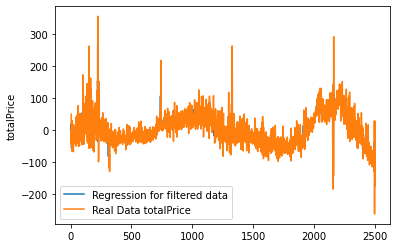

In [34]:
plt.plot(best_model.fittedvalues, label='Regression for filtered data')
plt.plot(data_stationary_ni['totalPrice'], label='Real Data totalPrice')
plt.ylabel('totalPrice')
plt.legend()
plt.show()



In [35]:
print(best_model.resid)

[18.30 -23.84 -22.01 ... -29.80 -0.40 -26.12]


Dickey-Fuller test: p=0.0000000000000000000000000
ShapiroResult(statistic=0.9085275530815125, pvalue=2.3653955744705633e-36)


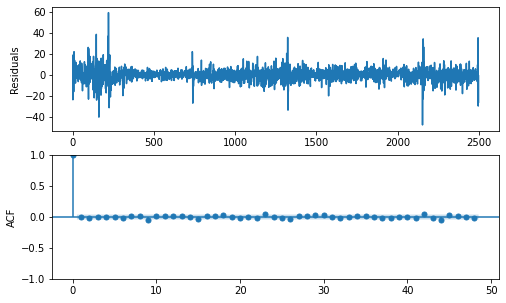

In [36]:
# Residuals
plt.figure(figsize=(8,5))
ax = plt.subplot(211)
plt.plot(best_model.resid)
plt.ylabel('Residuals')
#ACF
ax = plt.subplot(212)
sm.graphics.tsa.plot_acf(best_model.resid.squeeze(), lags=48, ax=ax, title=None)
plt.ylabel('ACF')
print("Dickey-Fuller test: p=%.25f" % sm.tsa.stattools.adfuller(best_model.resid)[1])
print (shapiro(best_model.resid))



### 7. Build model in a form of linear dynamical system, using chosen predictor

In [37]:
# Generating the predictor data               
X_data = data_stationary.drop('totalPrice',1)
X_data = X_data.drop('tradeTime',1)

# Generating the Target Data
Y_data = {'totalPrice': data_stationary['totalPrice']}  
Y_data = pd.DataFrame(Y_data)  

# Splitting data to training and testing data
test_num = len(data_stationary)*(1-0.2)//1
X_train, X_test, y_train, y_test = train_test_split(X_data, Y_data, test_size = 0.2, shuffle = False)
# building the VAR model
model = VAR(X_train)
# training the model
model_fit = model.fit()
model_fit.summary()



  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Sun, 12, Mar, 2023
Time:                     09:10:44
--------------------------------------------------------------------
No. of Equations:         2.00000    BIC:                    4.00558
Nobs:                     1998.00    HQIC:                   3.99494
Log likelihood:          -9648.86    FPE:                    53.9883
AIC:                      3.98877    Det(Omega_mle):         53.8265
--------------------------------------------------------------------
Results for equation square
                     coefficient       std. error           t-stat            prob
----------------------------------------------------------------------------------
const                   0.611665         0.309901            1.974           0.048
L1.square               0.139554         0.022127            6.307           0.000
L1.buildingType         0.920500         0.583341  

Residuals mean: 6.82803830159856e-16
Residuals std: 13.825521980769564
ShapiroResult(statistic=0.9049602150917053, pvalue=1.4599172394537367e-33)


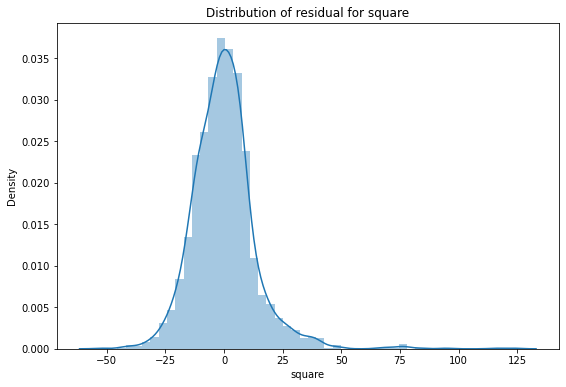

Residuals mean: 4.889871179530219e-18
Residuals std: 0.5301337834265104
ShapiroResult(statistic=0.696547269821167, pvalue=0.0)


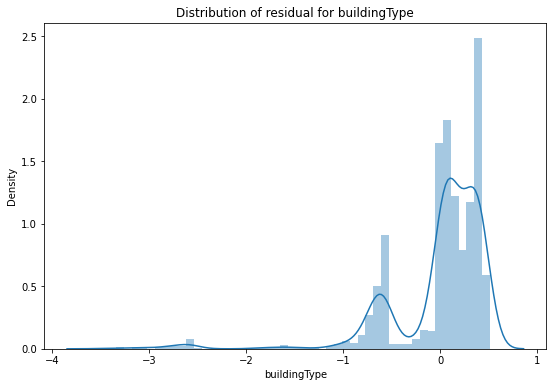

In [41]:
for item in model_fit.resid:
    residuals = model_fit.resid[item]
    fig, ax = plt.subplots(figsize=(9,6))
    sns.distplot(residuals, kde=True, norm_hist=True)
    plt.title('Distribution of residual for ' +str(item))
    print('Residuals mean: ' + str(residuals.mean()) +'\nResiduals std: '+str(residuals.std())+'\n'+str(shapiro(residuals)))
    plt.show()

